## Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regex as re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from operator import itemgetter

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis.sklearn

In [2]:
# stopwords e simbolos a retirar
stop_words_portugues = set(['co','de','a','o','que','e','é','do','da','em','um','para','com','não','uma','os','no','se','na','por','mais','as','dos','como','mas','ao','ele','das','à','seu','sua','ou','quando','muito','nos','já','eu','também','só','pelo','pela','até','isso','ela','entre','depois','sem','mesmo','aos','seus','quem','nas','me','esse','eles','você','essa','num','nem','suas','meu','às','minha','numa','pelos','elas','qual','nós','lhe','deles','essas','esses','pelas','este','dele','tu','te','vocês','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','está','estamos','estão','estive','esteve','estivemos','estiveram','estava','estávamos','estavam','estivera','estivéramos','esteja','estejamos','estejam','estivesse','estivéssemos','estivessem','estiver','estivermos','estiverem','hei','há','havemos','hão','houve','houvemos','houveram','houvera','houvéramos','haja','hajamos','hajam','houvesse','houvéssemos','houvessem','houver','houvermos','houverem','houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou','somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja','sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será','seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos','tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham','tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos','terão','teria','teríamos','teriam'])
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '.', '|'])

In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopico #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [5]:
def tweet_tokenizer(text):
    tweet = text.lower()
    tweet_token = [w for w in re.split('\W+', tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return emoji(" ".join(tweet_token))

<>:3: DeprecationWarning: invalid escape sequence \W
<>:3: DeprecationWarning: invalid escape sequence \W
<ipython-input-5-8f16e6b8bb11>:3: DeprecationWarning: invalid escape sequence \W
  tweet_token = [w for w in re.split('\W+', tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]


# Carregando os dados 

In [6]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
    cols = ['nome'] + [col for col in df_politicos if col != 'nome']
    df_politicos = df_politicos[cols]

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

In [7]:
df_politicos.head(10)

,nome,created_at,text,id
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296
5,Amoedo,2021-04-19T12:19:42Z,A CPI da Pandemia no Senado deve investigar o ...,1384119514418216969
6,Amoedo,2021-04-18T19:21:07Z,Leia a coluna completa em https://t.co/rvNDUpnqgA,1383863178853969921
7,Amoedo,2021-04-18T19:21:06Z,"""Membros do Executivo e do Legislativo não ace...",1383863176891015168
8,Amoedo,2021-04-18T15:42:35Z,Informações de @RevistaEpoca,1383808183223734272
9,Amoedo,2021-04-18T15:42:25Z,O governo federal gastará R$500 mil em uma cam...,1383808141897342986


In [8]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31633 entries, 0 to 1294
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nome        31633 non-null  object
 1   created_at  31633 non-null  object
 2   text        31633 non-null  object
 3   id          31633 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

## Dataframe de frequências e teste de stopwords

In [9]:
dados = set()
for politico in nome_politicos:
    # separando as palavras
    palavras = "".join(df_politicos[df_politicos['nome'] == politico]['text']).lower()
    palavras = re.split('\W+', palavras)
    # retirando stopwords, web links, simbolos e outros
    palavras = [w for w in palavras if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    palavras = [w for w in palavras if re.match(r'http*', w) == None]
    palavras = [w for w in palavras if not (w.startswith('@') | w.startswith('#'))]
    palavras = [w for w in palavras if w != 'rt']
    # gerando a frequência das palavras
    c = Counter(palavras)
    # retirando palavras com frequencia menor do que 10 e adicionando o nome do candidato
    d = {(politico,x,y) for x,y in zip(c,c.values()) if y > 10}
    print(politico, len(d))
    for x in d:
        dados.add(x)
        
# montando o dataframe
df = pd.DataFrame(dados, columns=['candidato', 'texto', 'frequencia'])

<>:5: DeprecationWarning: invalid escape sequence \W
<ipython-input-9-12e9d7efbfc4>:5: DeprecationWarning: invalid escape sequence \W
  palavras = re.split('\W+', palavras)


Amoedo 1156
Bolsonaro 849
Boulos 832
Ciro 679
Doria 897
Huck 568
Leite 1242
Lula 877
Mandetta 305
Marina 1070
Moro 384


C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarn

In [10]:
df[df['candidato'] == 'Moro'].head(50)

,candidato,texto,frequencia
32,Moro,mudar,11
34,Moro,tudo,22
83,Moro,organizações,15
109,Moro,setor,14
188,Moro,juntos,33
194,Moro,pacote,13
269,Moro,2020,14
322,Moro,perfis,22
343,Moro,medidas,33
386,Moro,lei,117


In [11]:
df.sort_values('frequencia', ascending=False)[:50]

,candidato,texto,frequencia
5506,Lula,lula,890
7339,Doria,sp,863
1320,Leite,rs,744
1994,Marina,governo,716
3740,Doria,paulo,579
6693,Ciro,bolsonaro,554
3206,Boulos,pra,552
968,Marina,presidente,551
1030,Leite,vamosriogrande,537
8273,Amoedo,brasil,536


## WordCloud de todos

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

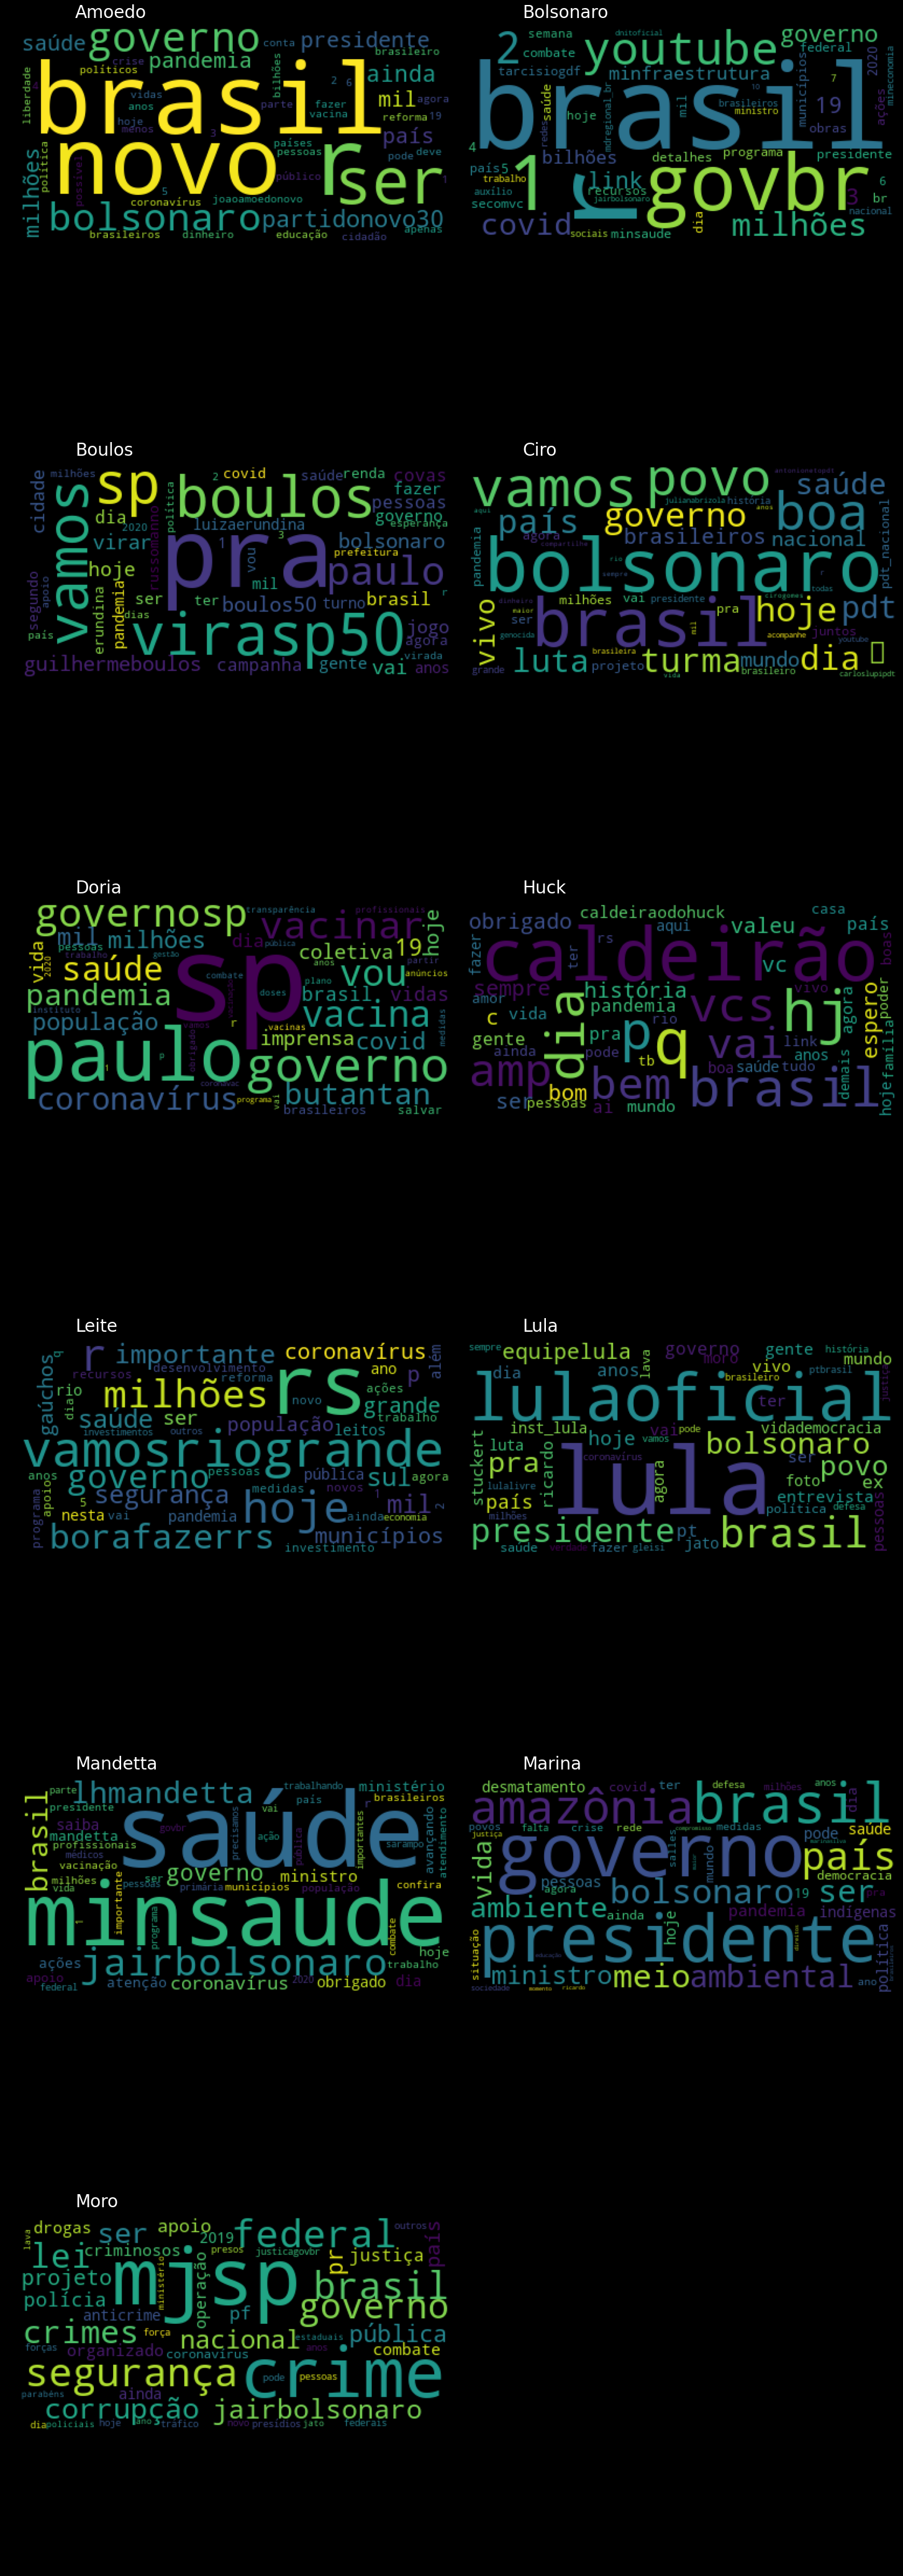

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='k')
xc = 0
yc = 0
for politico in nome_politicos:
    new_df = df[df['candidato'] == politico][['texto', 'frequencia']].sort_values('frequencia', ascending=False)[: 50]
    new_df = new_df.rename(columns={"texto": "words", "frequencia": "counts"})
    wordcloud = WordCloud().generate_from_frequencies(dict([tuple(x) for x in new_df.values]))
    ax[xc][yc].imshow(wordcloud)
    ax[xc][yc].text(50, -10, politico, fontsize=28, color='white')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.axis('off')
plt.tight_layout(pad=0) 
plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [13]:
df_politicos['tweet_token'] = 'NaN'
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.d

,nome,created_at,text,id,tweet_token
0,Amoedo,2021-04-19T16:18:20Z,RT @MBLivre: Presidente americano Joe Biden an...,1384179569712713735,mblivre presidente americano joe biden anuncia...
1,Amoedo,2021-04-19T16:05:53Z,Temos que fazer a nossa parte. Não podemos dei...,1384176435552608259,fazer parte podemos deixar brasil continuar an...
2,Amoedo,2021-04-19T15:32:40Z,O governo federal e o Congresso ignoraram no O...,1384168077697314825,governo federal congresso ignoraram orçamento ...
3,Amoedo,2021-04-19T12:53:14Z,RT @o_antagonista: .@joaoamoedonovo sugeriu no...,1384127951311040517,o_antagonista joaoamoedonovo sugeriu twitter t...
4,Amoedo,2021-04-19T12:25:58Z,Informações de @OGloboPolitica,1384121090243383296,informações oglobopolitica


In [14]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))
lda = LatentDirichletAllocation(n_components=55, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=55, random_state=0)

In [15]:
n_top_words = 10
print("\nTópico no Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Tópico no Modelo LDA: 
**********************************************************************

Topico #0:50 visita pior abraço abril mortos ceará francisco fotos comparação

Topico #1:vacina vacinar vidas salvar butantan civil vacinas setor doses polícia

Topico #2:sempre vou casa compromisso outras coletiva esperança ficar falar marinasilva

Topico #3:paulo novo gente pra aqui youtube agora muita valeu salles

Topico #4:saúde rs jairbolsonaro crime ministério segurança pública ministro profissionais municípios

Topico #5:informações instituto diálogo importante governadores santa acesse doação silva inovação

Topico #6:julianabrizola falecimento moderno turmaboa nacprogressista celebra orlandosilva protesto pôr julianabrizola12

Topico #7:governosp isolamento via govbr tarcisiogdf minfraestrutura foco virtual promover mineconomia

Topico #8:basta uol bombeiros historia mediação fhc band abrimos uoleleições2020 antirracista

Topico #9:planeta injusto adolescente sobral interview today

In [16]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds = 'tsne')
dash

C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
C:\Users\Roberto Tengan\anaconda3\lib\site-packages\pandas\core\internals\construction.py:587: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if dtype != object and dtype != np.object:
C:\Users\Roberto Tengan\anaconda3

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
38      71.279602 -111.276100       1        1  20.086844
41      56.941944 -105.550323       2        1  18.446438
52      57.545006 -123.499428       3        1  12.456325
4       37.997238   92.245193       4        1   4.710775
3       76.692627   56.861900       5        1   4.004110
43     100.649422   23.616785       6        1   4.001143
42      67.611320  -69.341660       7        1   3.474362
2      -42.730598  -82.278206       8        1   2.673627
34     104.589348  -12.517811       9        1   1.988436
1      -13.573278   92.857895      10        1   1.440464
53     -11.936131 -102.444954      11        1   1.321201
35      22.407055  -84.494469      12        1   1.184234
5      -51.605713   69.809174      13        1   1.172349
36     -86.230263    8.813145      14        1   1.137930
12     -71.190102   39.890972      15        1   1.114654
45      -4.231879  -72.614616      16        1   1.098159
37     -76.982918  -25.639114      17        1   1.069919
7      -70.717560  -58.953686      18        1   1.068368
29      71.149597  -11.833828      19        1   1.048843
17      84.754333  -41.465607      20        1   0.832093
13      55.555485  -38.879311      21        1   0.824776
0      -18.003256   61.165787      22        1   0.807655
51       9.987686   66.677284      23        1   0.774698
40      41.982021   59.049675      24        1   0.724413
33      68.347565   15.843328      25        1   0.688674
27      49.093716   33.216625      26        1   0.680050
26     -35.570759   42.091831      27        1   0.641475
10     -47.177788   20.413675      28        1   0.597567
15      35.912964  -59.223186      29        1   0.588724
25     -57.604290   -1.943275      30        1   0.558001
50     -46.090305  -43.664009      31        1   0.545520
18     -42.329079  -19.399231      32        1   0.514821
19      21.700027   43.380264      33        1   0.509966
11     -21.284716  -55.107368      34        1   0.482608
49     -24.309835  -32.818848      35        1   0.482152
44      -5.698748   39.391979      36        1   0.480743
20      11.175179  -51.558201      37        1   0.475025
47      46.016209    5.428885      38        1   0.395453
39     -22.317394   22.762423      39        1   0.365915
30      45.656239  -15.971052      40        1   0.354658
21     -33.061039    1.837567      41        1   0.347692
32      29.959114  -36.650074      42        1   0.344017
54      27.230614  -17.593287      43        1   0.341412
46      11.603179   26.141001      44        1   0.331064
23      -4.453694  -36.875782      45        1   0.313511
48      29.242989   18.951492      46        1   0.310687
8       26.762699    0.213064      47        1   0.288319
14     -19.345770  -13.495186      48        1   0.280465
28      -3.557868   16.624851      49        1   0.272248
22      11.882136  -27.517839      50        1   0.269495
6      -14.852765    3.854401      51        1   0.235621
31      -3.163131  -18.688580      52        1   0.232495
24      -1.406680   -2.781422      53        1   0.218252
9       11.211170    7.051121      54        1   0.213749
16      11.628026   -9.589048      55        1   0.177804, topic_info=             Term         Freq        Total Category  logprob  loglift
10392   bolsonaro  1943.000000  1943.000000  Default  30.0000  30.0000
49065       saúde  2124.000000  2124.000000  Default  29.0000  29.0000
34602        lula  1195.000000  1195.000000  Default  28.0000  28.0000
43300  presidente  2216.000000  2216.000000  Default  27.0000  27.0000
36457     milhões  1607.000000  1607.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
6389     alienada     1.744539     2.656486  Topic55  -6.2645   5.9117
5719    afugentar     1.561429     2.473375  Topic55  -6.3754   5.8723
11154    bár

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos Politicos

In [17]:
#tf_vectorizer = CountVectorizer()
#for politico in nome_politicos:
#    tf = tf_vectorizer.fit_transform((list(df_politicos[df_politicos['nome'] == politico]['tweet_token'])))
#    lda = LatentDirichletAllocation(n_components=5, max_iter=5,
#                                    learning_method = 'online',
#                                    learning_offset = 50.,
#                                    random_state = 0)
#    lda.fit(tf)

#    n_top_words = 3
#    print(f"\nTópico no Modelo LDA: {politico}")
#    tf_feature_names = tf_vectorizer.get_feature_names()
#    print_top_words(lda, tf_feature_names, n_top_words)
#    print("*"*70)
#    print("*"*70)
#    print("*"*70)